In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sksurv.metrics import concordance_index_censored
import numpy as np
import scipy.stats
from functools import partial
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

In [2]:
import sys
from pathlib import Path
from joblib import Parallel, delayed
import json

In [3]:
def mean_confidence_interval(data, confidence=0.95):
    """Calculate mean, and lower and upper bound of confidence interval"""
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [4]:
def Dxy(event_observed, cve_lifetime, predicted_scores):
    """Calculate Dxy

    Rescale values from 0<=x<=1 range, where 0 is perfect anti-concordance,
    and 0.5 is the expected result from random predictions,
    to the -1<=x<=1 range
    """
    #return 2 * concordance_index_censored(event_observed, cve_lifetime, predicted_scores)[0] - 1
    return 2 * concordance_index(cve_lifetime, predicted_scores, event_observed) - 1

In [5]:
def bootstrap_dxy_inner(df):
    """Bootstrapped Dxy calculation, randomly sampled with replacement

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe to sample to compute Dxy from concordance index.
        Assumes that first 3 columns in this dataframe are:

        1. boolean column denoting which events were observed (un-censored)
        2. column with event times, in this case CVE lifetime (time to fix)
        3. column with predicted score, assumed to be category number,
           ordered in such way that larger values predict shorter lifetime

        Other columns are not used.

    Returns
    -------
    float
        Coefficient of concordance correlation, a number between –1 and 1 that
        measures the strength and direction of the relationship between
        predicted score (risk factor) and event time (CVE survival lifetime).
    """
    e, y, x = df.columns
    sample = df.sample(n=df.shape[0], replace=True)

    # calculate Dxy from sample
    return Dxy(sample[e], sample[y], sample[x])


def bootstrap_dxy(df, n=5):
    """Boostrap and calculate Dxy, resampling `n` times"""
    # resample n times
    result = Parallel(n_jobs=-1)(delayed(bootstrap_dxy_inner)(df) for _ in range(n))

    return result

In [6]:
def apply_stats_for_each_value(params, df, fmap, condition_names=None, df_mask=None):
    """Apply stats to each value in column"""

    all_count = df.shape[0]

    if df_mask is not None:
        df = df[df_mask]

    dff = pd.DataFrame({'E': df['E'], 'Y': df['Y'], 'agg': df.apply(fmap, axis=1)}).dropna()
    selected_count = dff.shape[0]
    print(f"all = {all_count}, selected = {selected_count}, uncensored = {dff['E'].sum()}",
               file=sys.stderr)

    # DEBUG
    #print(dff.head())

    stats = dff['Y'].aggregate(['count', 'median'])

    print(f"Computing {params['bootstrap_samples']} × bootstrap Dxy " +
          f"for {dff.shape[0]} elements...", file=sys.stderr)
    dxy_bootstrapped = bootstrap_dxy(dff[['E', 'Y', 'agg']], params['bootstrap_samples'])
    # DEBUG
    #print(dxy_bootstrapped)
    # confidence interval
    print(f"Computing confidence interval from {len(dxy_bootstrapped)} samples...", file=sys.stderr)
    dxy, ci_low, ci_high = mean_confidence_interval(dxy_bootstrapped, confidence=params['confidence'])

    ret = {
        'Cohort': all_count,
        'Number of patients': stats['count'],
        '% of cohort': 100.0*selected_count / all_count,
        'Survival days, median': stats['median'],
        'Survival years, median': stats['median'] / 365,
        'Dxy (full)': Dxy(dff['E'], dff['Y'], dff['agg']),
        'bootstrap': {
            'Dxy': dxy,
            'Confidence interval low': ci_low,
            'Confidence interval high': ci_high,
            'confidence threshold %': 100.0*params['confidence'],
            'bootstrap samples': params['bootstrap_samples'],
        },
    }

    print("Computing descriptive statistics like mean, median, etc....", file=sys.stderr)
    dff_groupby_y = dff.groupby(by=['agg'])['Y']
    groups = dff_groupby_y\
        .agg(['count', 'median', 'min',
              lambda x: np.percentile(x, q=25), lambda x: np.percentile(x, q=75),
              'max', 'mean', 'std', 'skew'])\
        .rename(columns={'<lambda_0>': '25%', '<lambda_1>': '75%'})

    # DEBUG
    #print(dff_groupby_y.describe())

    groups.index.names = [ params['risk_column_name'] ]
    if condition_names:
        groups.index = groups.index.map(condition_names)

    return ret, groups, dff

In [7]:
def plot_survival_function(params, dff, condition_names=None):
    """Create plot of survival function

    Parameters
    ----------
    params : dict
        Uses params['cve_survival_analysis']['risk_column_name'] and
        params['description'] to create plot titles
    plot_path : str | pathlib.Path
        Where to save the plot
    dff : pandas.DataFrame
        The dataframe with data to compute survival function from
    condition_names : dict | None
        Mapping from risk factor score to risk factor name
    """
    values_list = dff["agg"].unique()
    if condition_names is not None:
        values_list = condition_names.keys()
    print(f"values_list = {values_list}")
    for value in values_list:
        mask = (dff["agg"] == value)  # it's a boolean-valued pd.Series
        time_cell, survival_prob_cell = kaplan_meier_estimator(dff["E"][mask], dff["Y"][mask])
        plt.step(time_cell, survival_prob_cell, where="post",
                 label=f"{condition_names[value]} (n = {mask.sum():d})"
                       if condition_names else
                       f"{value:d} (n = {mask.sum():d})"
                 )

    if 'risk_column_name' in params:
        plt.suptitle(f"Risk factor: '{params['risk_column_name']}'")
    if 'description' in params:
        plt.title(params['description'])
    plt.ylabel("est. probability of survival $\\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.legend(loc="best")
    plt.show()
    # plt.savefig(plot_path)
    plt.clf()

In [8]:
def create_values_ranking_list(column_s, column_dtype):
    # if column_dtype is ordered category, we can use the order;
    # or column_dtype is unordered category with two values, any order is good;
    # or column_dtype is some kind of integer, we can use values

    # or column_dtype == 'category'
    if isinstance(column_dtype, pd.CategoricalDtype):
        if column_dtype.ordered:
            # we can use category ordering as ranking
            return column_dtype.categories.to_list()
        if column_dtype.categories.shape[0] == 2:
            # any order is good, we can get correlation or anti-correlation
            return column_dtype.categories.to_list()

    if pd.api.types.is_string_dtype(column_dtype) \
            and column_s.nunique(dropna=True) == 2:
        return column_s.unique().tolist()

    # we can't create ranking list of values
    return None

In [9]:
def values_ranking_hashes(values_ranking_list):
    values_ranking_hash = { value: idx
                            for (idx, value) in enumerate(values_ranking_list) }
    rankings_condition_names = { idx: value
                                 for (idx, value) in enumerate(values_ranking_list) }

    return values_ranking_hash, rankings_condition_names

In [10]:
def f_map_int(row, column_name, min_value=None, max_value=None):
    value = int(row[column_name])
    if min_value is not None and value < min_value:
        return None
    if max_value is not None and value > max_value:
        return None

    return value


def f_map_bool(row, column_name):
    value = bool(row[column_name])
    return value


def f_map_generic(row, column_name, values_ranking_hash):
    value = row[column_name]
    if value in values_ranking_hash:
        return values_ranking_hash[value]

    return None

In [11]:
def uniquify(param):
    seen = set()
    uniq = []
    for elem in param:
        if elem not in seen:
            uniq.append(elem)
            seen.add(elem)

    return uniq

In [12]:
def read_df(input_df):
    print(f"Reading input dataframe from '{input_df}'...")
    df = pd.read_parquet(input_df)
    print(f"{df.shape[0]} elems")
    df = df.drop_duplicates()
    print(f"{df.shape[0]} width duplicates dropped")
    return df

## Read data

In [13]:
DATA_PREFIX="~jnareb/echoes_of_vulnerabilities_code/data/"

In [291]:
df = read_df(DATA_PREFIX + "cve_survival_input_df")

Reading input dataframe from '~jnareb/echoes_of_vulnerabilities_code/data/cve_survival_input_df'...
287884 elems
287884 width duplicates dropped


In [15]:
df.head()

,commit_cves,project_names,commits,used_dep_manager,cve_lifespan_commiter_time,cve_lifespan_author_time,embargo_min,embargo_max,lang_Shell,other_languages,...,LatestCommitDate,NumActiveMon,NumAuthors,NumCore,CommunitySize,NumCommits,NumBlobs,NumFiles,NumForks,NumStars
0,CVE-2002-0429,bitbucket.org_cagney_netbsd,1,0,4791 days 06:33:58,4791 days 06:33:58,False,False,1512.0,58463.0,...,2015-09-25 13:47:53+00:00,2,2,1,2,22,137167,144273,0,<NA>
1,CVE-2002-0429,bitbucket.org_cagney_netbsd,1,0,4791 days 06:33:58,4791 days 06:33:58,False,False,1512.0,58463.0,...,2015-09-25 13:47:53+00:00,2,2,1,2,22,137167,144273,0,<NA>
2,CVE-2002-0429,IIJ-NetBSD_netbsd-src,1,0,577 days 02:42:04,577 days 02:42:04,False,False,0.0,0.0,...,2021-03-12 04:57:42+00:00,338,470,72,83,310763,1496164,466280,81,164
3,CVE-2002-0429,NetBSD_src,22,0,577 days 02:42:04,577 days 02:42:04,False,False,0.0,0.0,...,2021-09-09 15:00:01+00:00,344,708,95,224,6250114,2303243,597353,230,514
4,CVE-2002-0429,bitbucket.org_cagney_netbsd,1,0,4791 days 06:33:58,4791 days 06:33:58,False,False,1512.0,58463.0,...,2015-09-25 13:47:53+00:00,2,2,1,2,22,137167,144273,0,<NA>


In [292]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287884 entries, 0 to 287883
Data columns (total 46 columns):
 #   Column                           Non-Null Count   Dtype              
---  ------                           --------------   -----              
 0   commit_cves                      287884 non-null  object             
 1   project_names                    287884 non-null  object             
 2   commits                          287884 non-null  int64              
 3   used_dep_manager                 287884 non-null  int64              
 4   cve_lifespan_commiter_time       287884 non-null  timedelta64[ns]    
 5   cve_lifespan_author_time         287884 non-null  timedelta64[ns]    
 6   embargo_min                      287884 non-null  bool               
 7   embargo_max                      287884 non-null  bool               
 8   lang_Shell                       287884 non-null  float64            
 9   other_languages                  287884 non-null  float64  

In [17]:
True < False

False

In [18]:
(df['embargo_min'] < df['embargo_max']).value_counts()

False    287884
dtype: int64

Project metadata columns to analyze
- [x] CommitDateRange \[days] = (LatestCommitDate - EarliestCommitDate).dt.days
- [x] NumActiveMon
    - [x] NumActiveMon \[%]
- [x] NumAuthors
    - [x] NumCore / NumAuthors
- [x] NumCore
- [x] NumCommits
- [x] NumStars
- [x] NumForks
- [x] CommunitySize
- [x] NumFiles
- [x] NumBlobs

In [19]:
df.describe()

,commits,used_dep_manager,cve_lifespan_commiter_time,cve_lifespan_author_time,lang_Shell,other_languages,value,programming_paradigm,compilation_class,type_class,...,cvss,NumActiveMon,NumAuthors,NumCore,CommunitySize,NumCommits,NumBlobs,NumFiles,NumForks,NumStars
count,287884.000000,287884.000000,287884,287884,287884.000000,287884.000000,287884.000000,287884.000000,287884.000000,287884.000000,...,286848.000000,287884.000000,287040.000000,287040.000000,287876.000000,2.875950e+05,2.878840e+05,2.878840e+05,287876.000000,228169.000000
mean,7.882470,0.136843,805 days 11:32:44.092242016,777 days 11:58:19.469543320,191.510570,2992.361809,416.710661,1.306894,1.522797,1.517431,...,5.825607,125.926748,5660.891374,247.696941,6339.450840,1.834722e+06,1.234389e+06,5.705731e+05,11131.559810,15738.112057
std,47.519313,1.007577,1079 days 17:14:38.861165248,1026 days 21:47:17.506519280,345.637555,8232.715201,3761.104188,0.710714,0.499481,0.499697,...,1.920419,119.699092,21216.673708,751.429312,22615.227119,7.170781e+06,4.021697e+06,1.714456e+06,45994.074477,46962.572570
min,1.000000,0.000000,0 days 00:00:00,0 days 00:00:00,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,0.000000,1.000000
25%,1.000000,0.000000,49 days 07:50:01.500000,38 days 03:24:06,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,4.300000,13.000000,4.000000,2.000000,2.000000,2.400000e+01,5.354300e+04,2.896700e+04,0.000000,2.000000
50%,1.000000,0.000000,368 days 01:16:41,336 days 14:47:05,1.000000,21.000000,5.000000,1.000000,2.000000,2.000000,...,5.000000,80.000000,75.000000,10.000000,6.000000,4.762000e+03,1.623890e+05,1.055120e+05,5.000000,35.000000
75%,5.000000,0.000000,1151 days 11:44:09,1151 days 22:06:19,166.000000,4862.000000,30.000000,1.000000,2.000000,2.000000,...,7.200000,235.000000,2207.000000,213.000000,1184.000000,3.610380e+05,6.949690e+05,3.155660e+05,1340.000000,11954.000000
max,2349.000000,51.000000,8019 days 14:41:17,8019 days 14:41:17,11867.000000,153573.000000,616542.000000,3.000000,2.000000,2.000000,...,10.000000,698.000000,109725.000000,16920.000000,154323.000000,3.646839e+07,3.604579e+07,4.307279e+07,237104.000000,285958.000000


## Analyze

In [295]:
df['E'] = True
df['Y']=df['cve_lifespan_commiter_time'].dt.days

In [296]:
df[['Y','E']].describe()

,Y
count,287884.000000
mean,804.992702
std,1079.697016
min,0.000000
25%,49.000000
50%,368.000000
75%,1151.000000
max,8019.000000


Limit to lifetime $\le$ 365 days

In [297]:
df_full=df
df=df[df['Y'] <= 365]
#df

In [298]:
df[['Y','E']].describe()

,Y
count,143486.000000
mean,92.666964
std,103.068081
min,0.000000
25%,9.000000
50%,49.000000
75%,154.000000
max,365.000000


In [299]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143486 entries, 36 to 287883
Data columns (total 48 columns):
 #   Column                           Non-Null Count   Dtype              
---  ------                           --------------   -----              
 0   commit_cves                      143486 non-null  object             
 1   project_names                    143486 non-null  object             
 2   commits                          143486 non-null  int64              
 3   used_dep_manager                 143486 non-null  int64              
 4   cve_lifespan_commiter_time       143486 non-null  timedelta64[ns]    
 5   cve_lifespan_author_time         143486 non-null  timedelta64[ns]    
 6   embargo_min                      143486 non-null  bool               
 7   embargo_max                      143486 non-null  bool               
 8   lang_Shell                       143486 non-null  float64            
 9   other_languages                  143486 non-null  float64 

In [156]:
results_summary={}

### NumCore and NumAuthors

**NumCore**

<AxesSubplot: ylabel='Count'>

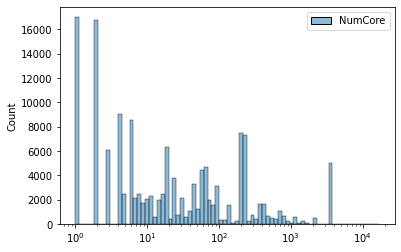

In [157]:
sns.histplot(data=df[['NumCore']].dropna(),log_scale=True)

NumCore_cut
[1.0, 2.0)         17034
[2.0, 10.0)        49322
[10.0, 100.0)      44888
[100.0, 1000.0)    25755
[1000.0, inf)       6431
dtype: int64

CategoricalDtype(categories=[[1.0, 2.0), [2.0, 10.0), [10.0, 100.0), [100.0, 1000.0), [1000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumCore_cut', ylabel='CVE+project'>

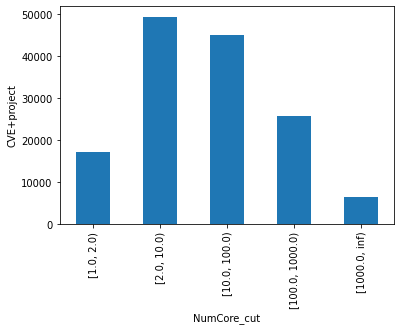

In [285]:
numcore_cut = pd.cut(df['NumCore'].dropna(),
                     bins=[1,2,10,100,1000,np.inf],right=False,include_lowest=True)
df['NumCore_cut'] = numcore_cut
display(df.value_counts('NumCore_cut').sort_index())
display(numcore_cut.dtype)

df.value_counts('NumCore_cut').sort_index().plot.bar(ylabel='CVE+project')

In [159]:
column_name='NumCore'
column_cut='NumCore_cut'
ranking_list = create_values_ranking_list(df['NumCore_cut'], df['NumCore_cut'].dtype)
ranking_list

[Interval(1.0, 2.0, closed='left'),
 Interval(2.0, 10.0, closed='left'),
 Interval(10.0, 100.0, closed='left'),
 Interval(100.0, 1000.0, closed='left'),
 Interval(1000.0, inf, closed='left')]

In [160]:
(values_hash, values_names) = values_ranking_hashes(ranking_list)

In [161]:
f_map = lambda row: f_map_generic(row, 'NumCore_cut', values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': 'NumCore_cut',
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=None)

print(json.dumps(ret, indent=4))
display(groups)
#display(ddf)

all = 143486, selected = 143430, uncensored = 143430
Computing 50 × bootstrap Dxy for 143430 elements...
Computing confidence interval from 50 samples...
Computing descriptive statistics like mean, median, etc....


{'Cohort': 143486,
 'Number of patients': 143430.0,
 '% of cohort': 99.96097180212703,
 'Survival days, median': 49.0,
 'Survival years, median': 0.13424657534246576,
 'Dxy (full)': 0.09502025175884987,
 'bootstrap': {'Dxy': 0.0952954213237204,
  'Confidence interval low': 0.09477183820210565,
  'Confidence interval high': 0.09581900444533516,
  'confidence threshold %': 95.0,
  'bootstrap samples': 50}}

,count,median,min,25%,75%,max,mean,std,skew
NumCore_cut,,,,,,,,,
"[1.0, 2.0)",17034,38.0,0,11.0,140.0,365,87.278619,101.278988,1.230243
"[2.0, 10.0)",49322,34.0,0,5.0,133.0,365,81.665748,99.346380,1.244519
"[10.0, 100.0)",44888,37.0,0,7.0,118.0,365,78.272434,94.127619,1.362841
"[100.0, 1000.0)",25755,110.0,0,32.0,226.0,365,134.459056,111.939416,0.490270
"[1000.0, inf)",6431,90.0,0,33.0,204.0,365,124.609548,107.645859,0.647763


In [162]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

values_list = dict_keys([0, 1, 2, 3, 4])


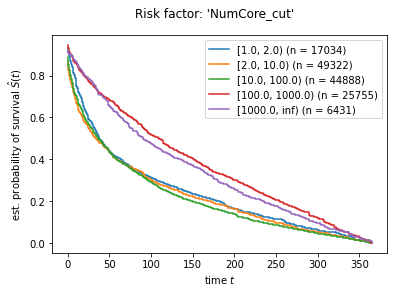

<Figure size 432x288 with 0 Axes>

In [163]:
plot_survival_function(params, ddf, condition_names=values_names)

<AxesSubplot: xlabel='Y', ylabel='NumCore_cut'>

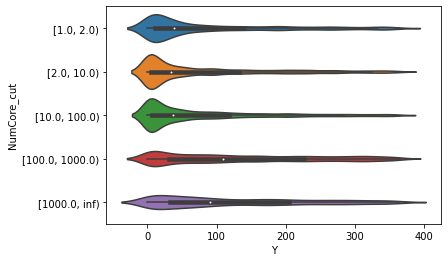

In [164]:
sns.violinplot(data=df, x="Y", y="NumCore_cut")

----

/tmp/ipykernel_3832658/180084078.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NumCore_cut2'] = numcore_cut


NumCore_cut2
[10.0, inf)    77074
[1.0, 10.0)    66356
dtype: int64

CategoricalDtype(categories=[[1.0, 10.0), [10.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumCore_cut2', ylabel='CVE+project'>

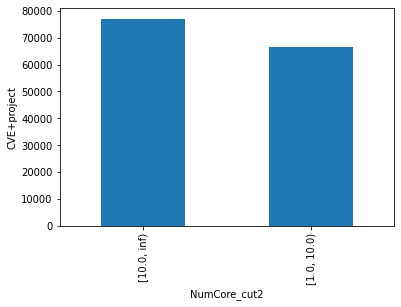

In [165]:
numcore_cut = pd.cut(df['NumCore'].dropna(),
                     bins=[1,10,np.inf],right=False,include_lowest=True)
df['NumCore_cut2'] = numcore_cut
display(df.value_counts('NumCore_cut2'))
display(numcore_cut.dtype)

df.value_counts('NumCore_cut2').plot.bar(ylabel='CVE+project')

In [166]:
ranking_list = create_values_ranking_list(df['NumCore_cut2'], df['NumCore_cut2'].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

In [167]:
f_map = lambda row: f_map_generic(row, 'NumCore_cut2', values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': 'NumCore_cut2',
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=None)

print(json.dumps(ret, indent=4))
display(groups)
#display(ddf)

all = 143486, selected = 143430, uncensored = 143430
Computing 50 × bootstrap Dxy for 143430 elements...
Computing confidence interval from 50 samples...
Computing descriptive statistics like mean, median, etc....


{'Cohort': 143486,
 'Number of patients': 143430.0,
 '% of cohort': 99.96097180212703,
 'Survival days, median': 49.0,
 'Survival years, median': 0.13424657534246576,
 'Dxy (full)': 0.05804937690079104,
 'bootstrap': {'Dxy': 0.05798396941337039,
  'Confidence interval low': 0.05765862099505563,
  'Confidence interval high': 0.05830931783168515,
  'confidence threshold %': 95.0,
  'bootstrap samples': 50}}

,count,median,min,25%,75%,max,mean,std,skew
NumCore_cut2,,,,,,,,,
"[1.0, 10.0)",66356,36.0,0,7.0,134.0,365,83.106607,99.875393,1.240944
"[10.0, inf)",77074,60.0,0,12.0,168.0,365,100.914057,105.048814,0.953767


In [168]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

values_list = dict_keys([0, 1])


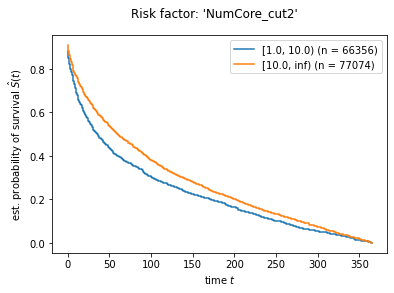

<Figure size 432x288 with 0 Axes>

In [169]:
plot_survival_function(params, ddf, condition_names=values_names)

<AxesSubplot: xlabel='Y', ylabel='NumCore_cut2'>

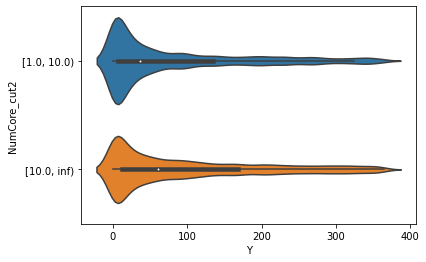

In [281]:
sns.violinplot(data=df, x="Y", y="NumCore_cut2")

<AxesSubplot: xlabel='NumCore', ylabel='Y'>

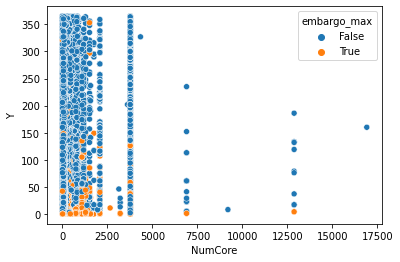

In [171]:
sns.scatterplot(data=df, x='NumCore', y='Y', hue='embargo_max')

-----
**NumAuthors**

<AxesSubplot: ylabel='Count'>

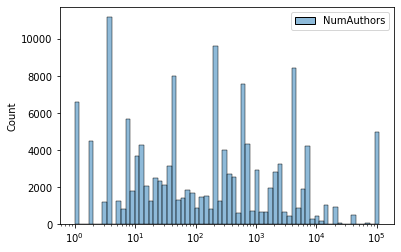

In [172]:
sns.histplot(data=df[['NumAuthors']].dropna(),log_scale=True)

/tmp/ipykernel_3832658/3339898687.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumAuthors_cut
[1.0, 4.0)         12264
[4.0, 6.0)         12403
[6.0, 100.0)       43909
[100.0, 1000.0)    37891
[1000.0, inf)      36963
dtype: int64

CategoricalDtype(categories=[[1.0, 4.0), [4.0, 6.0), [6.0, 100.0), [100.0, 1000.0), [1000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumAuthors_cut', ylabel='CVE+project'>

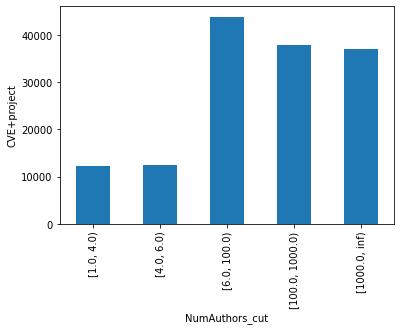

In [173]:
column_name = 'NumAuthors'
column_cut = column_name + '_cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,4,6,100,1e3,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [174]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

{0: Interval(1.0, 4.0, closed='left'),
 1: Interval(4.0, 6.0, closed='left'),
 2: Interval(6.0, 100.0, closed='left'),
 3: Interval(100.0, 1000.0, closed='left'),
 4: Interval(1000.0, inf, closed='left')}

In [175]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 143486, selected = 143430, uncensored = 143430
Computing 50 × bootstrap Dxy for 143430 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 143486,
    "Number of patients": 143430.0,
    "% of cohort": 99.96097180212703,
    "Survival days, median": 49.0,
    "Survival years, median": 0.13424657534246576,
    "Dxy (full)": 0.04604431982073964,
    "bootstrap": {
        "Dxy": 0.04637455575182873,
        "Confidence interval low": 0.04588226450914813,
        "Confidence interval high": 0.046866846994509326,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew
NumAuthors_cut,,,,,,,,,
"[1.0, 4.0)",12264,56.0,0,15.0,187.0,365,104.111791,106.937044,0.888031
"[4.0, 6.0)",12403,142.0,0,55.0,235.0,365,154.107151,107.516470,0.268117
"[6.0, 100.0)",43909,22.0,0,3.0,82.0,365,61.103510,86.117938,1.782263
"[100.0, 1000.0)",37891,32.0,0,6.0,111.0,365,72.975878,90.455717,1.456409
"[1000.0, inf)",36963,94.0,0,27.0,215.0,365,125.967346,111.146876,0.605485


In [176]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

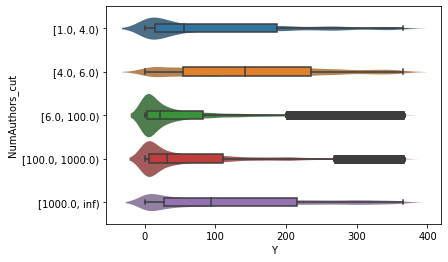

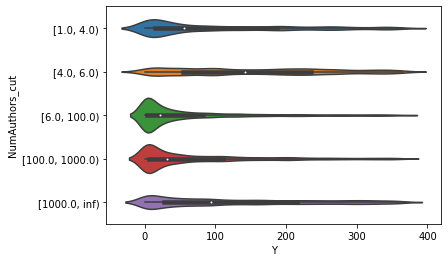

In [177]:
ax = sns.violinplot(data=df, x="Y", y=column_cut,
                    inner=None, width=1.0, linewidth=0, saturation=0.4)
sns.boxplot(data=df, x="Y", y=column_cut,
            width=0.2, boxprops={'zorder': 2}, ax=ax)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

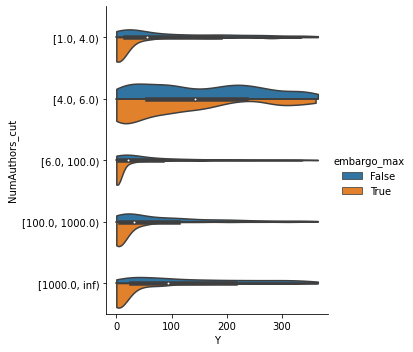

In [178]:
sns.catplot(
    data=df, x="Y", y="NumAuthors_cut", hue="embargo_max",
    kind="violin", bw=.25, cut=0, split=True,
)

{0: Interval(1.0, 4.0, closed='left'), 1: Interval(4.0, 6.0, closed='left'), 2: Interval(6.0, 100.0, closed='left'), 3: Interval(100.0, 1000.0, closed='left'), 4: Interval(1000.0, inf, closed='left')}
dict_keys([0, 1, 2, 3, 4])
values_list = dict_keys([0, 1, 2, 3, 4])


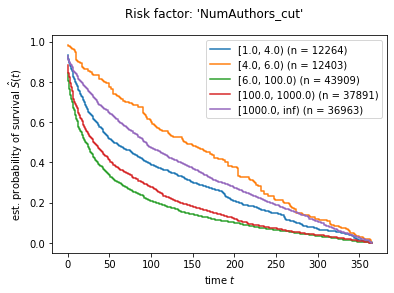

<Figure size 432x288 with 0 Axes>

In [179]:
print(values_names)
print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

<AxesSubplot: xlabel='NumAuthors', ylabel='Y'>

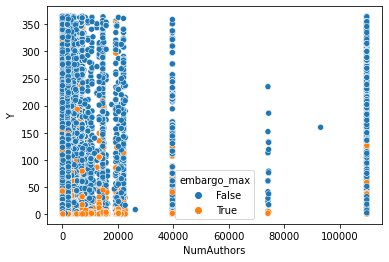

In [180]:
sns.scatterplot(data=df, x='NumAuthors', y='Y', hue='embargo_max')

### NumCore / NumAuthors

<AxesSubplot: xlabel='NumAuthors', ylabel='NumCore'>

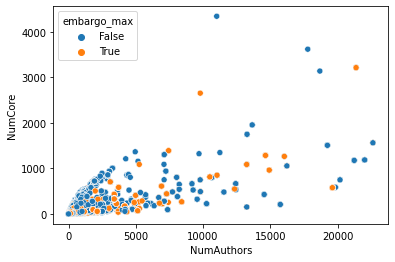

In [181]:
sns.scatterplot(data=df[df['NumAuthors']<25000], x='NumAuthors', y='NumCore', hue='embargo_max')

<AxesSubplot: xlabel='NumAuthors', ylabel='NumCore'>

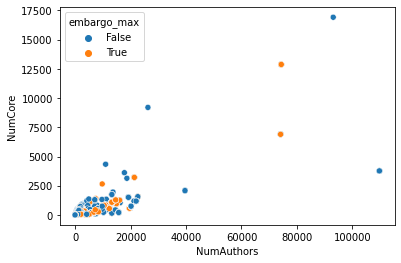

In [182]:
sns.scatterplot(data=df, x='NumAuthors', y='NumCore', hue='embargo_max')

In [183]:
df['NumCore/NumAuthors'] = df['NumCore'] / df['NumAuthors']
df['NumCore/NumAuthors'].describe()

/tmp/ipykernel_3832658/998512510.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NumCore/NumAuthors'] = df['NumCore'] / df['NumAuthors']


count    143430.000000
mean          0.230004
std           0.246280
min           0.003810
25%           0.055556
50%           0.129032
75%           0.333333
max           1.000000
Name: NumCore/NumAuthors, dtype: float64

In [184]:
df['NumCore/NumAuthors'][df['NumAuthors'] > 4].describe()

count    119981.000000
mean          0.147204
std           0.132768
min           0.003810
25%           0.053816
50%           0.100000
75%           0.179104
max           0.875000
Name: NumCore/NumAuthors, dtype: float64

<AxesSubplot: ylabel='Count'>

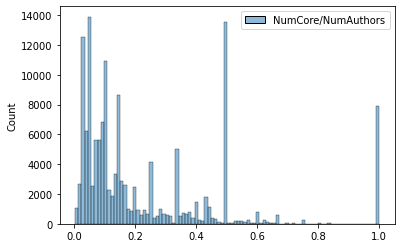

In [185]:
sns.histplot(data=df[['NumCore/NumAuthors']].dropna())

<AxesSubplot: ylabel='Count'>

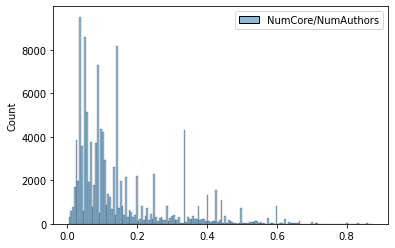

In [186]:
sns.histplot(data=df[['NumCore/NumAuthors']][df['NumAuthors']>4].dropna())

/tmp/ipykernel_3832658/3641574535.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumCore/NumAuthors cut
[0.0, 0.333)      104867
[0.333, 0.667)     29595
[0.667, 1.001)      8968
dtype: int64

CategoricalDtype(categories=[[0.0, 0.333), [0.333, 0.667), [0.667, 1.001)], ordered=True)

<AxesSubplot: xlabel='NumCore/NumAuthors cut', ylabel='CVE+project'>

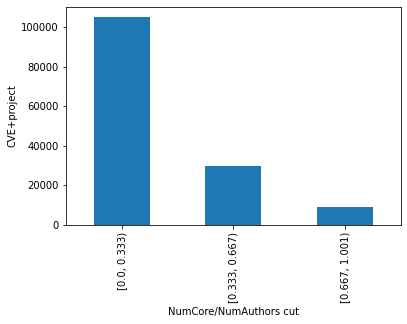

In [187]:
column_name = 'NumCore/NumAuthors'
column_cut = column_name + ' cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[0,1.0/3.0,2.0/3.0,1.001],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [188]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

{0: Interval(0.0, 0.333, closed='left'),
 1: Interval(0.333, 0.667, closed='left'),
 2: Interval(0.667, 1.001, closed='left')}

In [189]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 143486, selected = 143430, uncensored = 143430
Computing 50 × bootstrap Dxy for 143430 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 143486,
    "Number of patients": 143430.0,
    "% of cohort": 99.96097180212703,
    "Survival days, median": 49.0,
    "Survival years, median": 0.13424657534246576,
    "Dxy (full)": 0.0812328850464592,
    "bootstrap": {
        "Dxy": 0.0813517185835242,
        "Confidence interval low": 0.08096556864156376,
        "Confidence interval high": 0.08173786852548465,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew
NumCore/NumAuthors cut,,,,,,,,,
"[0.0, 0.333)",104867,37.0,0,6.0,130.0,365,83.251614,99.257701,1.257584
"[0.333, 0.667)",29595,100.0,0,28.0,218.0,365,128.626288,109.573444,0.540057
"[0.667, 1.001)",8968,40.0,0,11.0,130.0,365,84.236173,98.532390,1.291471


In [190]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

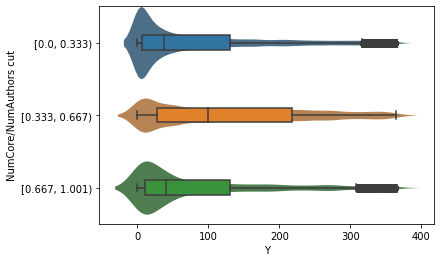

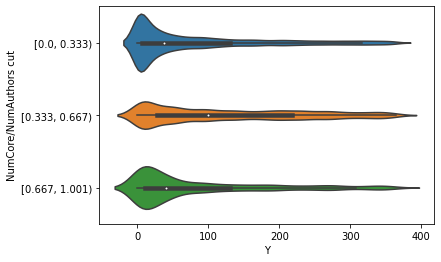

In [191]:
ax = sns.violinplot(data=df, x="Y", y=column_cut,
                    inner=None, width=1.0, linewidth=0, saturation=0.4)
sns.boxplot(data=df, x="Y", y=column_cut,
            width=0.2, boxprops={'zorder': 2}, ax=ax)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

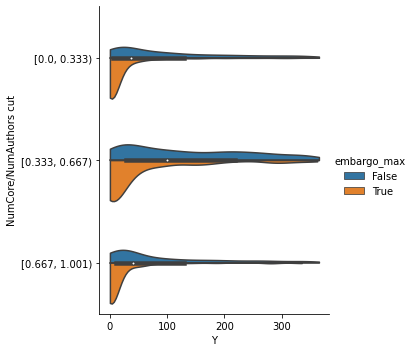

In [192]:
sns.catplot(
    data=df, x="Y", y=column_cut, hue="embargo_max",
    kind="violin", bw=.25, cut=0, split=True,
)

{0: Interval(0.0, 0.333, closed='left'), 1: Interval(0.333, 0.667, closed='left'), 2: Interval(0.667, 1.001, closed='left')}
dict_keys([0, 1, 2])
values_list = dict_keys([0, 1, 2])


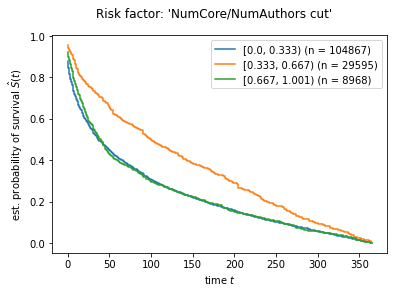

<Figure size 432x288 with 0 Axes>

In [193]:
print(values_names)
print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

<AxesSubplot: xlabel='Y', ylabel='NumCore/NumAuthors'>

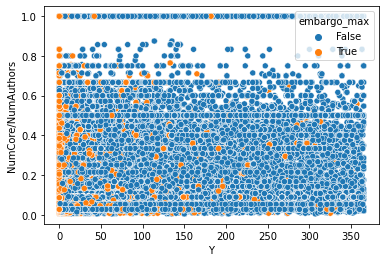

In [194]:
sns.scatterplot(data=df, y=column_name, x='Y', hue='embargo_max')

<AxesSubplot: xlabel='Y', ylabel='NumCore/NumAuthors'>

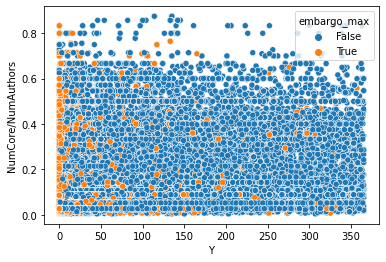

In [195]:
sns.scatterplot(data=df[df['NumAuthors']>4], y=column_name, x='Y', hue='embargo_max')

### NumCommits

<AxesSubplot: ylabel='Count'>

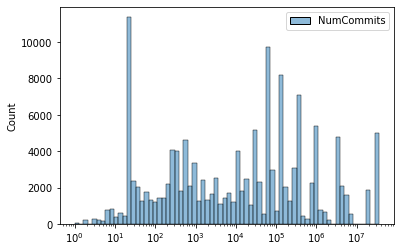

In [196]:
sns.histplot(data=df[['NumCommits']].dropna(), log_scale=True)

/tmp/ipykernel_3832658/1991781596.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumCommits_cut
[1.0, 10.0)               2545
[10.0, 100.0)            22008
[100.0, 1000.0)          24998
[1000.0, 10000.0)        15483
[10000.0, 100000.0)      30123
[100000.0, 1000000.0)    30389
[1000000.0, inf)         17782
dtype: int64

CategoricalDtype(categories=[[1.0, 10.0), [10.0, 100.0), [100.0, 1000.0), [1000.0, 10000.0), [10000.0, 100000.0), [100000.0, 1000000.0), [1000000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumCommits_cut', ylabel='CVE+project'>

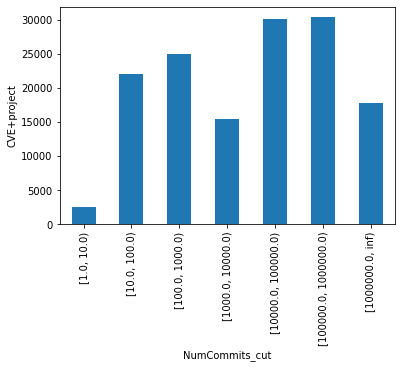

In [197]:
column_name = 'NumCommits'
column_cut = column_name + '_cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,10,100,1000,10000,100000,1000000,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

all = 143486, selected = 143328, uncensored = 143328
Computing 50 × bootstrap Dxy for 143328 elements...
Computing confidence interval from 50 samples...
Computing descriptive statistics like mean, median, etc....


{'Cohort': 143486,
 'Number of patients': 143328.0,
 '% of cohort': 99.88988472742986,
 'Survival days, median': 49.0,
 'Survival years, median': 0.13424657534246576,
 'Dxy (full)': -0.033463821705331465,
 'bootstrap': {'Dxy': -0.033881054193114934,
  'Confidence interval low': -0.03434266203668851,
  'Confidence interval high': -0.03341944634954136,
  'confidence threshold %': 95.0,
  'bootstrap samples': 50}}

,count,median,min,25%,75%,max,mean,std,skew
NumCommits_cut,,,,,,,,,
"[1.0, 10.0)",2545,130.0,0,25.0,195.0,365,127.412967,102.266656,0.428582
"[10.0, 100.0)",22008,100.0,0,24.0,224.0,365,130.163032,110.955201,0.520255
"[100.0, 1000.0)",24998,32.0,0,8.0,95.0,365,70.457757,90.517563,1.615026
"[1000.0, 10000.0)",15483,55.0,0,10.0,161.0,365,96.772202,103.730816,0.992900
"[10000.0, 100000.0)",30123,21.0,0,2.0,98.0,365,64.373270,87.464633,1.586813
"[100000.0, 1000000.0)",30389,57.0,0,11.0,181.0,365,104.973905,110.688814,0.893948
"[1000000.0, inf)",17782,61.0,0,15.0,157.0,365,96.132775,99.441829,1.061315


values_list = dict_keys([0, 1, 2, 3, 4, 5, 6])


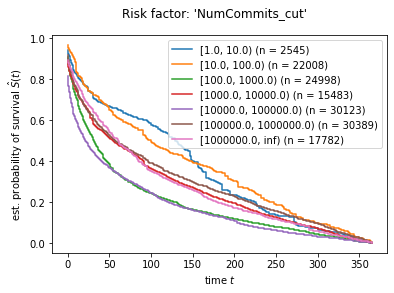

<Figure size 432x288 with 0 Axes>

In [198]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=None)

print(json.dumps(ret, indent=4))
display(groups)
#display(ddf)

plot_survival_function(params, ddf, condition_names=values_names)

In [199]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

<AxesSubplot: xlabel='Y', ylabel='NumCommits_cut'>

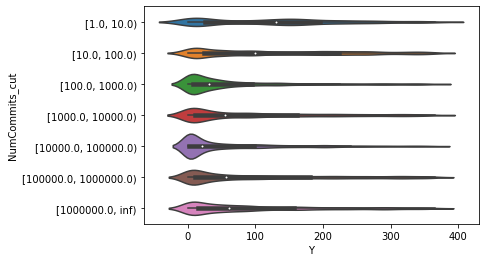

In [200]:
sns.violinplot(data=df, x="Y", y="NumCommits_cut")

/tmp/ipykernel_3832658/436446493.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumCommits_cut2
[1.0, 100.0)         24553
[100.0, 100000.0)    70604
[100000.0, inf)      48171
dtype: int64

CategoricalDtype(categories=[[1.0, 100.0), [100.0, 100000.0), [100000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumCommits_cut2', ylabel='CVE+project'>

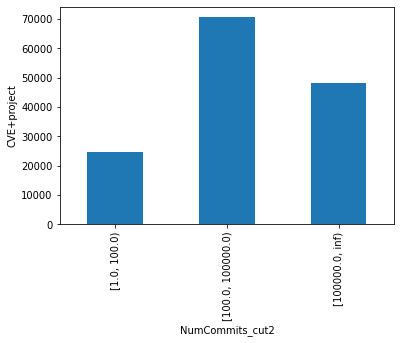

In [201]:
column_name = 'NumCommits'
column_cut = column_name + '_cut2'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,100,100000,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

all = 143486, selected = 143328, uncensored = 143328
Computing 50 × bootstrap Dxy for 143328 elements...
Computing confidence interval from 50 samples...
Computing descriptive statistics like mean, median, etc....


{'Cohort': 143486,
 'Number of patients': 143328.0,
 '% of cohort': 99.88988472742986,
 'Survival days, median': 49.0,
 'Survival years, median': 0.13424657534246576,
 'Dxy (full)': -0.02051688717950051,
 'bootstrap': {'Dxy': -0.020236002405109022,
  'Confidence interval low': -0.02066431013083991,
  'Confidence interval high': -0.019807694679378134,
  'confidence threshold %': 95.0,
  'bootstrap samples': 50}}

,count,median,min,25%,75%,max,mean,std,skew
NumCommits_cut2,,,,,,,,,
"[1.0, 100.0)",24553,101.0,0,24.0,222.0,365,129.877978,110.087687,0.514074
"[100.0, 100000.0)",70604,30.0,0,5.0,109.0,365,73.632415,93.175994,1.443738
"[100000.0, inf)",48171,59.0,0,13.0,170.0,365,101.710261,106.759467,0.957062


values_list = dict_keys([0, 1, 2])


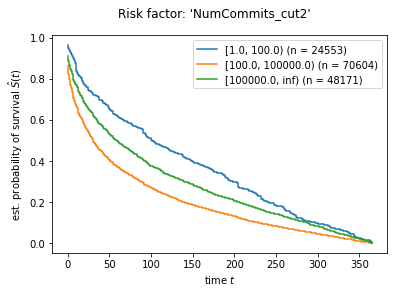

<Figure size 432x288 with 0 Axes>

In [202]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=None)

print(json.dumps(ret, indent=4))
display(groups)
#display(ddf)

plot_survival_function(params, ddf, condition_names=values_names)

In [203]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

<AxesSubplot: xlabel='Y', ylabel='NumCommits_cut2'>

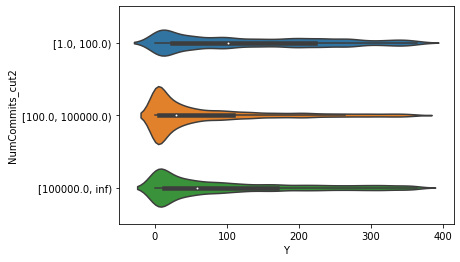

In [204]:
sns.violinplot(data=df, x="Y", y="NumCommits_cut2")

<AxesSubplot: xlabel='NumCommits', ylabel='Y'>

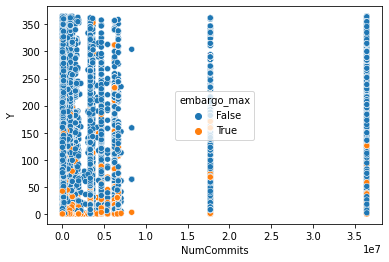

In [205]:
sns.scatterplot(data=df, x='NumCommits', y='Y', hue='embargo_max')

### NumMon and ActiveMon \[%]

In [206]:
df['CommitDateRange']=df['LatestCommitDate']-df['EarliestCommitDate']
df['CommitDateRange [days]']=df['CommitDateRange'].dt.days
df['CommitDateRange [mon]']=\
12 * (df['LatestCommitDate'].dt.year  - df['EarliestCommitDate'].dt.year) +\
     (df['LatestCommitDate'].dt.month - df['EarliestCommitDate'].dt.month)

df[['CommitDateRange [days]', 'CommitDateRange [mon]']].describe()

/tmp/ipykernel_3832658/2436893064.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CommitDateRange']=df['LatestCommitDate']-df['EarliestCommitDate']
/tmp/ipykernel_3832658/2436893064.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CommitDateRange [days]']=df['CommitDateRange'].dt.days
/tmp/ipykernel_3832658/2436893064.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

,CommitDateRange [days],CommitDateRange [mon]
count,143486.000000,143486.000000
mean,6455.104359,212.065867
std,7644.847183,251.116667
min,0.000000,0.000000
25%,2006.000000,65.000000
50%,3869.000000,127.000000
75%,7863.000000,258.000000
max,81273.000000,2671.000000


<AxesSubplot: xlabel='CommitDateRange [days]', ylabel='NumActiveMon'>

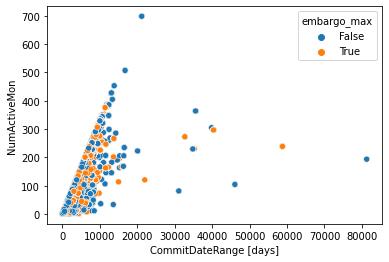

In [207]:
sns.scatterplot(data=df, x='CommitDateRange [days]', y='NumActiveMon', hue='embargo_max')

<AxesSubplot: xlabel='CommitDateRange [days]', ylabel='CommitDateRange [mon]'>

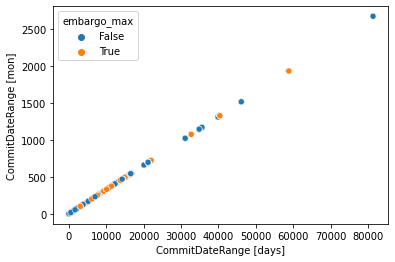

In [208]:
sns.scatterplot(data=df, x='CommitDateRange [days]', y='CommitDateRange [mon]', hue='embargo_max')

In [209]:
df['NumActiveMon [%]']=100.0*df['NumActiveMon']/(df['CommitDateRange [mon]']+1)
df[['NumActiveMon [%]']].describe()

/tmp/ipykernel_3832658/571980132.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NumActiveMon [%]']=100.0*df['NumActiveMon']/(df['CommitDateRange [mon]']+1)


,NumActiveMon [%]
count,143486.000000
mean,73.987920
std,27.538478
min,1.379310
25%,48.837209
50%,83.783784
75%,100.000000
max,200.000000


<AxesSubplot: ylabel='Count'>

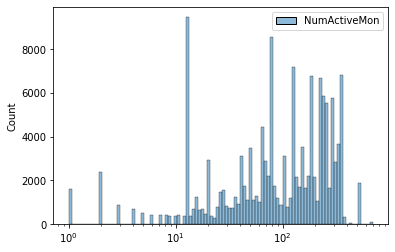

In [210]:
sns.histplot(data=df[['NumActiveMon']].dropna(), log_scale=True)

<AxesSubplot: ylabel='Count'>

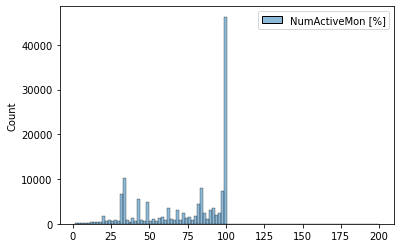

In [211]:
sns.histplot(data=df[['NumActiveMon [%]']].dropna())

/tmp/ipykernel_3832658/3759419786.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumActiveMon [%] cut
[-0.1, 25.0)       5853
[25.0, 50.0)      32850
[50.0, 75.0)      19556
[75.0, 100.0)     46763
[100.0, 200.0)    38463
dtype: int64

CategoricalDtype(categories=[[-0.1, 25.0), [25.0, 50.0), [50.0, 75.0), [75.0, 100.0), [100.0, 200.0)], ordered=True)

<AxesSubplot: xlabel='NumActiveMon [%] cut', ylabel='CVE+project'>

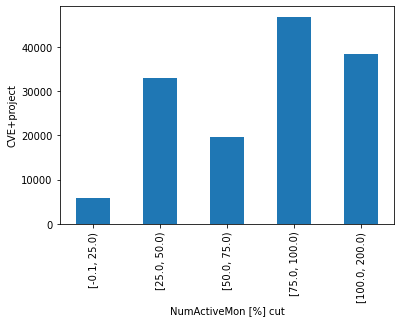

In [212]:
column_name = 'NumActiveMon [%]'
column_cut = column_name + ' cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[-0.1,25,50,75,100,200],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

all = 143486, selected = 143485, uncensored = 143485
Computing 50 × bootstrap Dxy for 143485 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 143486,
    "Number of patients": 143485.0,
    "% of cohort": 99.99930306789513,
    "Survival days, median": 49.0,
    "Survival years, median": 0.13424657534246576,
    "Dxy (full)": -0.11168943590921643,
    "bootstrap": {
        "Dxy": -0.11168003881421358,
        "Confidence interval low": -0.11206861855114518,
        "Confidence interval high": -0.11129145907728198,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew
NumActiveMon [%] cut,,,,,,,,,
"[-0.1, 25.0)",5853,51.0,0,8.0,157.00,365,95.705108,105.432875,1.029379
"[25.0, 50.0)",32850,98.0,0,27.0,217.75,365,127.090137,108.998726,0.557461
"[50.0, 75.0)",19556,42.0,0,8.0,136.00,365,87.515443,102.799345,1.202739
"[75.0, 100.0)",46763,38.0,0,9.0,122.00,365,80.601779,94.688484,1.325519
"[100.0, 200.0)",38463,31.0,0,3.0,125.00,365,80.095234,100.776428,1.306380


values_list = dict_keys([0, 1, 2, 3, 4])


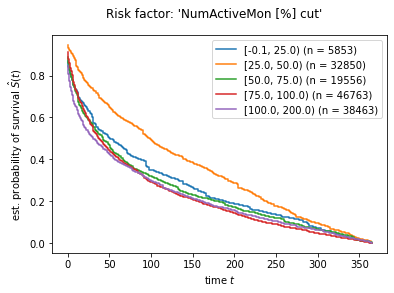

<Figure size 432x288 with 0 Axes>

In [213]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=None)

print(json.dumps(ret, indent=4))
display(groups)
#display(ddf)

plot_survival_function(params, ddf, condition_names=values_names)

In [214]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

<AxesSubplot: xlabel='Y', ylabel='NumActiveMon [%] cut'>

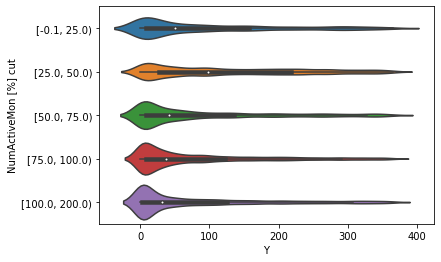

In [215]:
sns.violinplot(data=df, x="Y", y="NumActiveMon [%] cut")

<AxesSubplot: xlabel='NumActiveMon [%]', ylabel='Y'>

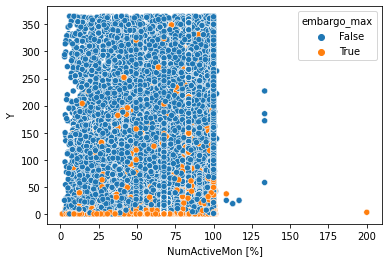

In [216]:
sns.scatterplot(data=df, x='NumActiveMon [%]', y='Y', hue='embargo_max')

/tmp/ipykernel_3832658/3704680564.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumActiveMon_cut
[1, 10)         7670
[10, 100)      61257
[100, 1000)    74559
dtype: int64

CategoricalDtype(categories=[[1, 10), [10, 100), [100, 1000)], ordered=True)

<AxesSubplot: xlabel='NumActiveMon_cut', ylabel='CVE+project'>

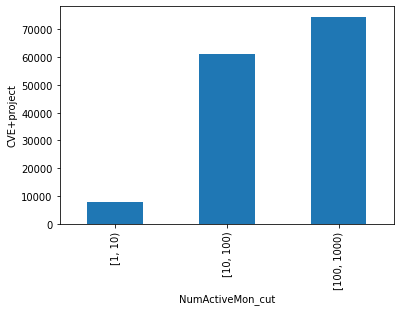

In [217]:
column_name = 'NumActiveMon'
column_cut = column_name + '_cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,10,100,1000],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [218]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

print(values_names)

{0: Interval(1, 10, closed='left'), 1: Interval(10, 100, closed='left'), 2: Interval(100, 1000, closed='left')}


all = 143486, selected = 143486, uncensored = 143486
Computing 50 × bootstrap Dxy for 143486 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 143486,
    "Number of patients": 143486.0,
    "% of cohort": 100.0,
    "Survival days, median": 49.0,
    "Survival years, median": 0.13424657534246576,
    "Dxy (full)": -0.07984653676152897,
    "bootstrap": {
        "Dxy": -0.0798770505654682,
        "Confidence interval low": -0.08032784520484763,
        "Confidence interval high": -0.07942625592608878,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew
NumActiveMon_cut,,,,,,,,,
"[1, 10)",7670,124.0,0,22.0,226.0,365,134.264146,112.578877,0.395691
"[10, 100)",61257,55.0,0,14.0,164.0,365,98.348744,102.908355,1.009630
"[100, 1000)",74559,36.0,0,5.0,133.0,365,83.719698,100.771030,1.235125


values_list = dict_keys([0, 1, 2])


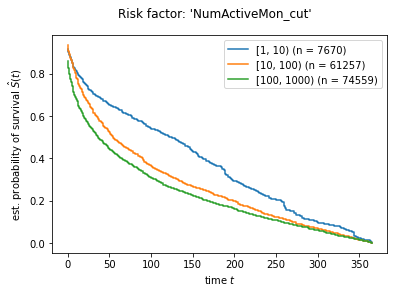

<Figure size 432x288 with 0 Axes>

In [219]:
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=None)

print(json.dumps(ret, indent=4))
display(groups)
#display(ddf)

plot_survival_function(params, ddf, condition_names=values_names)

In [220]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

<AxesSubplot: xlabel='Y', ylabel='NumActiveMon_cut'>

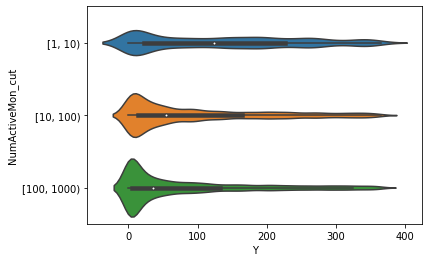

In [221]:
sns.violinplot(data=df, x="Y", y="NumActiveMon_cut")

<AxesSubplot: xlabel='NumActiveMon', ylabel='Y'>

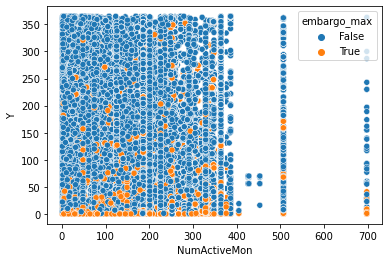

In [222]:
sns.scatterplot(data=df, x='NumActiveMon', y='Y', hue='embargo_max')

-----
**CommitDateRange \[days]**

In [223]:
column_name='CommitDateRange [days]'

In [224]:
df['CommitDateRange [days]'].describe()

count    143486.000000
mean       6455.104359
std        7644.847183
min           0.000000
25%        2006.000000
50%        3869.000000
75%        7863.000000
max       81273.000000
Name: CommitDateRange [days], dtype: float64

<AxesSubplot: ylabel='Count'>

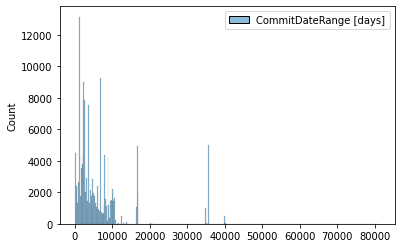

In [225]:
column_name='CommitDateRange [days]'
sns.histplot(data=df[[column_name]].dropna())

<AxesSubplot: ylabel='Count'>

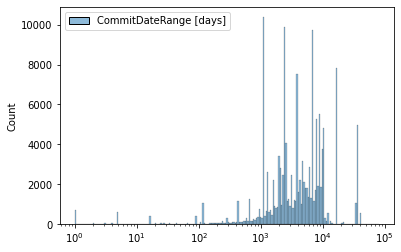

In [226]:
column_name='CommitDateRange [days]'
sns.histplot(data=df[[column_name]].dropna()+1, log_scale=True)

/tmp/ipykernel_3832658/1267421467.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


CommitDateRange [days] cut
[0.0, 30.0)           2208
[30.0, 365.0)         3300
[365.0, 1000.0)       6166
[1000.0, 5000.0)     69523
[5000.0, 10000.0)    39524
[10000.0, inf)       22765
dtype: int64

CategoricalDtype(categories=[[0.0, 30.0), [30.0, 365.0), [365.0, 1000.0), [1000.0, 5000.0), [5000.0, 10000.0), [10000.0, inf)], ordered=True)

<AxesSubplot: xlabel='CommitDateRange [days] cut', ylabel='CVE+project'>

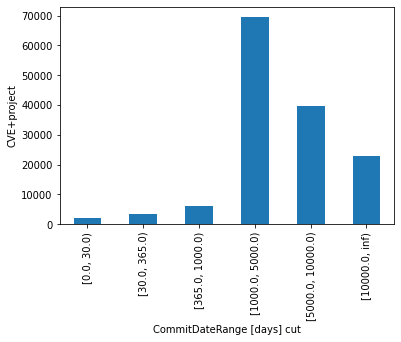

In [227]:
column_name = 'CommitDateRange [days]'
column_cut = column_name + ' cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[0,30,365,1e3,5e3,1e4,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [228]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

{0: Interval(0.0, 30.0, closed='left'),
 1: Interval(30.0, 365.0, closed='left'),
 2: Interval(365.0, 1000.0, closed='left'),
 3: Interval(1000.0, 5000.0, closed='left'),
 4: Interval(5000.0, 10000.0, closed='left'),
 5: Interval(10000.0, inf, closed='left')}

In [229]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 143486, selected = 143486, uncensored = 143486
Computing 50 × bootstrap Dxy for 143486 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 143486,
    "Number of patients": 143486.0,
    "% of cohort": 100.0,
    "Survival days, median": 49.0,
    "Survival years, median": 0.13424657534246576,
    "Dxy (full)": 0.002985354510857796,
    "bootstrap": {
        "Dxy": 0.0028656484794882297,
        "Confidence interval low": 0.002466279903478104,
        "Confidence interval high": 0.0032650170554983553,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew
CommitDateRange [days] cut,,,,,,,,,
"[0.0, 30.0)",2208,111.0,0,21.0,215.0,363,129.383152,110.016833,0.465923
"[30.0, 365.0)",3300,185.0,0,53.0,261.0,365,165.082424,114.042126,0.034072
"[365.0, 1000.0)",6166,53.0,0,9.0,156.0,365,91.475349,99.251307,1.076677
"[1000.0, 5000.0)",69523,42.0,0,9.0,137.0,365,86.012428,98.837261,1.201942
"[5000.0, 10000.0)",39524,38.0,0,5.0,143.0,365,87.750708,105.246534,1.165811
"[10000.0, inf)",22765,72.0,0,20.0,178.0,365,107.789326,104.256140,0.862524


In [230]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

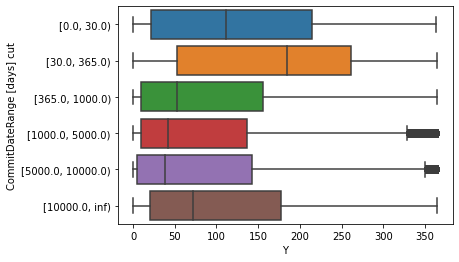

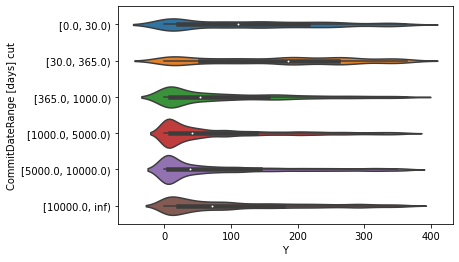

In [231]:
sns.boxplot(data=df, x="Y", y=column_cut)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

{0: Interval(0.0, 30.0, closed='left'), 1: Interval(30.0, 365.0, closed='left'), 2: Interval(365.0, 1000.0, closed='left'), 3: Interval(1000.0, 5000.0, closed='left'), 4: Interval(5000.0, 10000.0, closed='left'), 5: Interval(10000.0, inf, closed='left')}
dict_keys([0, 1, 2, 3, 4, 5])
values_list = dict_keys([0, 1, 2, 3, 4, 5])


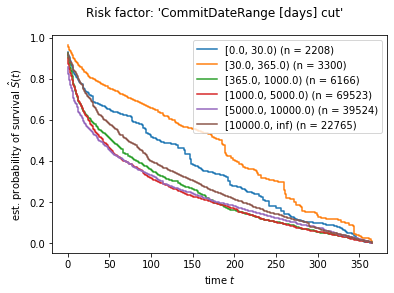

<Figure size 432x288 with 0 Axes>

In [232]:
print(values_names)
print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

<AxesSubplot: xlabel='CommitDateRange [days]', ylabel='Y'>

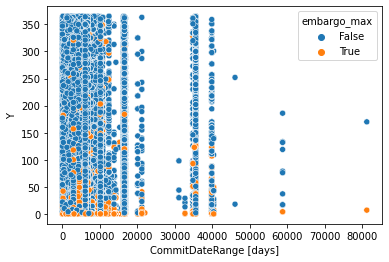

In [233]:
sns.scatterplot(data=df, x=column_name, y='Y', hue='embargo_max')

<AxesSubplot: xlabel='CommitDateRange [days]', ylabel='Y'>

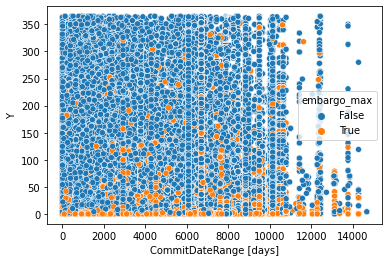

In [234]:
sns.scatterplot(data=df[df[column_name]<15000], x=column_name, y='Y', hue='embargo_max')

### Popularity: NumStars

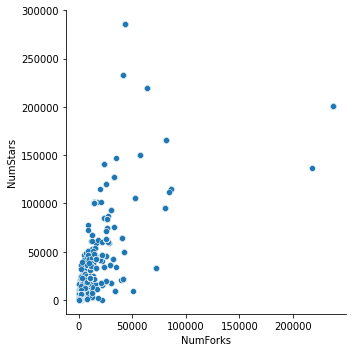

In [235]:
sns.relplot(df[['NumForks','NumStars']].dropna(),x='NumForks',y='NumStars')
plt.show()

<AxesSubplot: ylabel='Count'>

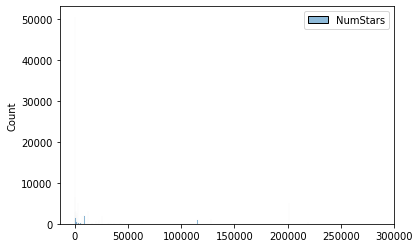

<AxesSubplot: ylabel='Count'>

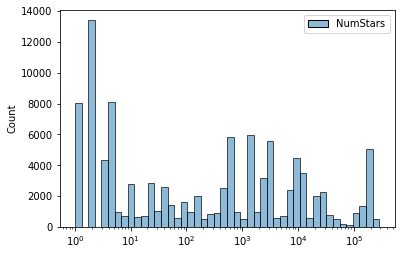

In [236]:
sns.histplot(data=df[['NumStars']].dropna())
plt.show()
sns.histplot(data=df[['NumStars']].dropna(), log_scale=True)
plt.show()

/tmp/ipykernel_3832658/472104740.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumStars_cut
[1.0, 2.0)              8014
[2.0, 5.0)             24440
[5.0, 10.0)             3771
[10.0, 100.0)          12487
[100.0, 1000.0)        15933
[1000.0, 10000.0)      24136
[10000.0, 100000.0)     9917
[100000.0, inf)         7854
dtype: int64

CategoricalDtype(categories=[[1.0, 2.0), [2.0, 5.0), [5.0, 10.0), [10.0, 100.0), [100.0, 1000.0), [1000.0, 10000.0), [10000.0, 100000.0), [100000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumStars_cut', ylabel='CVE+project'>

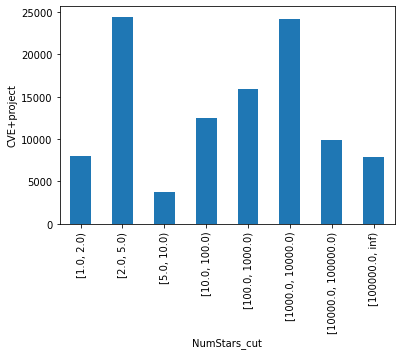

In [237]:
column_name = 'NumStars'
column_cut = column_name + '_cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,2,5,10,100,1000,10000,100000,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

/tmp/ipykernel_3832658/2701432508.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumStars_cut
[1.0, 3.0)          21429
[3.0, 100.0)        27283
[100.0, 10000.0)    40069
[10000.0, inf)      17771
dtype: int64

CategoricalDtype(categories=[[1.0, 3.0), [3.0, 100.0), [100.0, 10000.0), [10000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumStars_cut', ylabel='CVE+project'>

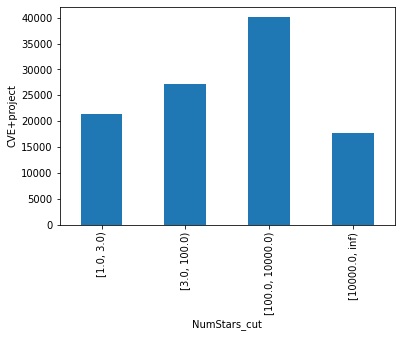

In [238]:
column_name = 'NumStars'
column_cut = column_name + '_cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,3,100,10000,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

all = 143486, selected = 106552, uncensored = 106552
Computing 50 × bootstrap Dxy for 106552 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 143486,
    "Number of patients": 106552.0,
    "% of cohort": 74.259509638571,
    "Survival days, median": 59.0,
    "Survival years, median": 0.16164383561643836,
    "Dxy (full)": 0.016705261065755428,
    "bootstrap": {
        "Dxy": 0.01643390803751217,
        "Confidence interval low": 0.01589260769293485,
        "Confidence interval high": 0.01697520838208949,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew
NumStars_cut,,,,,,,,,
"[1.0, 3.0)",21429,91.0,0,17.0,217.0,365,121.918708,111.308231,0.589108
"[3.0, 100.0)",27283,36.0,0,8.0,119.0,365,81.230363,98.160505,1.361127
"[100.0, 10000.0)",40069,54.0,0,11.0,146.0,365,90.580998,96.631660,1.086980
"[10000.0, inf)",17771,92.0,0,23.0,234.0,365,130.582466,117.083472,0.552203


values_list = dict_keys([0, 1, 2, 3])


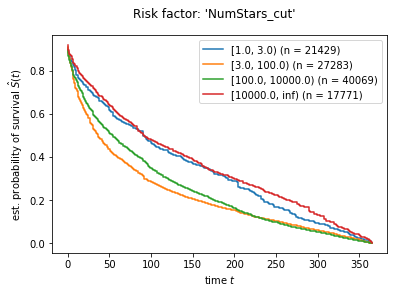

<Figure size 432x288 with 0 Axes>

In [239]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=None)

print(json.dumps(ret, indent=4))
display(groups)
#display(ddf)

plot_survival_function(params, ddf, condition_names=values_names)

In [240]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

<AxesSubplot: xlabel='Y', ylabel='NumStars_cut'>

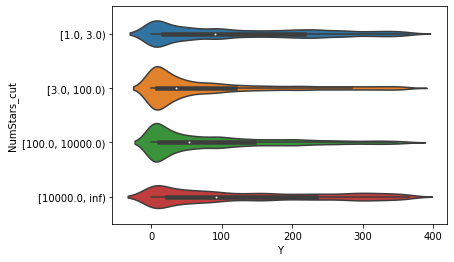

In [241]:
sns.violinplot(data=df, x="Y", y="NumStars_cut")

In [242]:
df_mask = df['NumStars'] < 10000
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)
#display(ddf)

#plot_survival_function(params, ddf, condition_names=values_names)

all = 143486, selected = 88781, uncensored = 88781
Computing 50 × bootstrap Dxy for 88781 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 143486,
    "Number of patients": 88781.0,
    "% of cohort": 61.87432920284906,
    "Survival days, median": 54.0,
    "Survival years, median": 0.14794520547945206,
    "Dxy (full)": -0.04549159453267537,
    "bootstrap": {
        "Dxy": -0.045277770242578536,
        "Confidence interval low": -0.04594330887991662,
        "Confidence interval high": -0.04461223160524045,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew
NumStars_cut,,,,,,,,,
"[1.0, 3.0)",21429,91.0,0,17.0,217.0,365,121.918708,111.308231,0.589108
"[3.0, 100.0)",27283,36.0,0,8.0,119.0,365,81.230363,98.160505,1.361127
"[100.0, 10000.0)",40069,54.0,0,11.0,146.0,365,90.580998,96.631660,1.086980


In [243]:
results_summary[f"{column_cut}+NumStars<10000"] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

<AxesSubplot: xlabel='NumStars', ylabel='Y'>

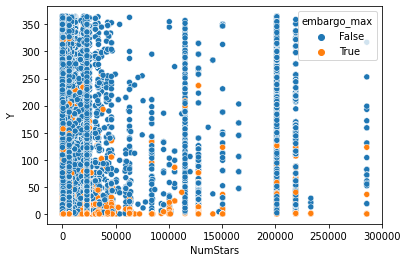

In [244]:
sns.scatterplot(data=df, x='NumStars', y='Y', hue='embargo_max')

-----
**NumForks**

In [245]:
df.columns

Index(['commit_cves', 'project_names', 'commits', 'used_dep_manager',
       'cve_lifespan_commiter_time', 'cve_lifespan_author_time', 'embargo_min',
       'embargo_max', 'lang_Shell', 'other_languages', 'variable', 'value',
       'programming_paradigm', 'Programming paradigm', 'compilation_class',
       'Compilation class', 'type_class', 'Type class', 'memory_model',
       'Memory model', 'extended_programming_paradigm',
       'Programming paradigm (extended)', 'cve', 'cvss', 'cwe', 'cvss-vector',
       'access.authentication', 'access.complexity', 'access.vector',
       'impact.availability', 'impact.confidentiality', 'impact.integrity',
       'CVSS v2.0 Ratings', 'CVSS v3.1 Ratings', 'RootFork',
       'EarliestCommitDate', 'LatestCommitDate', 'NumActiveMon', 'NumAuthors',
       'NumCore', 'CommunitySize', 'NumCommits', 'NumBlobs', 'NumFiles',
       'NumForks', 'NumStars', 'E', 'Y', 'NumCore_cut', 'NumCore_cut2',
       'NumAuthors_cut', 'NumCore/NumAuthors', 'NumCore/NumA

In [246]:
df[['NumForks','NumStars']].describe()

,NumForks,NumStars
count,143479.000000,106552.000000
mean,10454.421936,16319.308563
std,43923.188434,47801.106320
min,0.000000,1.000000
25%,0.000000,4.000000
50%,6.000000,228.000000
75%,827.000000,2902.000000
max,237104.000000,285958.000000


<AxesSubplot: ylabel='Count'>

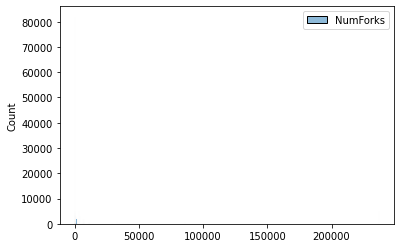

<AxesSubplot: ylabel='Count'>

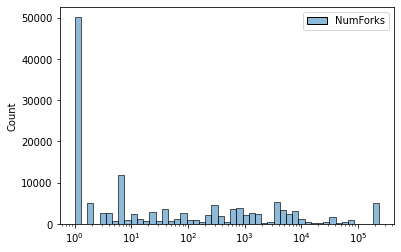

In [247]:
sns.histplot(data=df[['NumForks']].dropna())
plt.show()
sns.histplot(data=df[['NumForks']].dropna()+1, log_scale=True)
plt.show()

/tmp/ipykernel_3832658/2530176179.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumForks_cut
[0.0, 1.0)        50167
[1.0, 5.0)        11182
[5.0, 10.0)       13489
[10.0, 1000.0)    36389
[1000.0, inf)     32252
dtype: int64

CategoricalDtype(categories=[[0.0, 1.0), [1.0, 5.0), [5.0, 10.0), [10.0, 1000.0), [1000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumForks_cut', ylabel='CVE+project'>

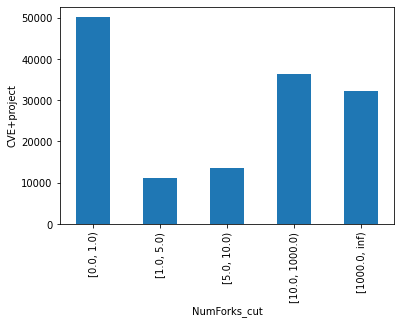

In [248]:
column_name = 'NumForks'
column_cut = column_name + '_cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[0,1,5,10,1e3,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [249]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

{0: Interval(0.0, 1.0, closed='left'),
 1: Interval(1.0, 5.0, closed='left'),
 2: Interval(5.0, 10.0, closed='left'),
 3: Interval(10.0, 1000.0, closed='left'),
 4: Interval(1000.0, inf, closed='left')}

In [250]:
df.columns

Index(['commit_cves', 'project_names', 'commits', 'used_dep_manager',
       'cve_lifespan_commiter_time', 'cve_lifespan_author_time', 'embargo_min',
       'embargo_max', 'lang_Shell', 'other_languages', 'variable', 'value',
       'programming_paradigm', 'Programming paradigm', 'compilation_class',
       'Compilation class', 'type_class', 'Type class', 'memory_model',
       'Memory model', 'extended_programming_paradigm',
       'Programming paradigm (extended)', 'cve', 'cvss', 'cwe', 'cvss-vector',
       'access.authentication', 'access.complexity', 'access.vector',
       'impact.availability', 'impact.confidentiality', 'impact.integrity',
       'CVSS v2.0 Ratings', 'CVSS v3.1 Ratings', 'RootFork',
       'EarliestCommitDate', 'LatestCommitDate', 'NumActiveMon', 'NumAuthors',
       'NumCore', 'CommunitySize', 'NumCommits', 'NumBlobs', 'NumFiles',
       'NumForks', 'NumStars', 'E', 'Y', 'NumCore_cut', 'NumCore_cut2',
       'NumAuthors_cut', 'NumCore/NumAuthors', 'NumCore/NumA

In [251]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 143486, selected = 143479, uncensored = 143479
Computing 50 × bootstrap Dxy for 143479 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 143486,
    "Number of patients": 143479.0,
    "% of cohort": 99.99512147526588,
    "Survival days, median": 49.0,
    "Survival years, median": 0.13424657534246576,
    "Dxy (full)": 0.11265790152892907,
    "bootstrap": {
        "Dxy": 0.11256097690967351,
        "Confidence interval low": 0.11210089883072173,
        "Confidence interval high": 0.11302105498862529,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew
NumForks_cut,,,,,,,,,
"[0.0, 1.0)",50167,25.0,0,5.0,102.0,365,69.880519,92.882114,1.533782
"[1.0, 5.0)",11182,34.0,0,5.0,134.0,365,82.255947,101.244366,1.250069
"[5.0, 10.0)",13489,139.0,0,55.0,235.0,365,152.827118,107.334866,0.280872
"[10.0, 1000.0)",36389,40.0,0,8.0,120.0,365,80.174091,94.317739,1.350999
"[1000.0, inf)",32252,88.0,0,22.0,204.0,365,120.649603,110.067573,0.668157


In [252]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

<AxesSubplot: xlabel='Y', ylabel='NumForks_cut'>

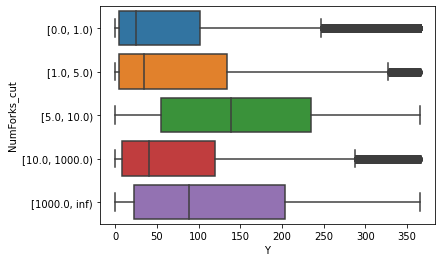

In [253]:
sns.boxplot(data=df, x="Y", y="NumForks_cut")

<AxesSubplot: xlabel='Y', ylabel='NumForks_cut'>

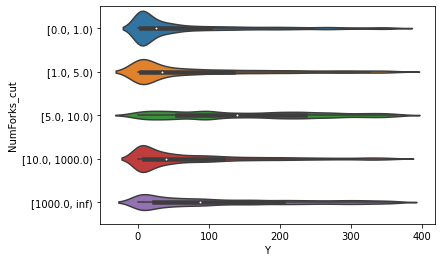

In [254]:
sns.violinplot(data=df, x="Y", y="NumForks_cut")

{0: Interval(0.0, 1.0, closed='left'), 1: Interval(1.0, 5.0, closed='left'), 2: Interval(5.0, 10.0, closed='left'), 3: Interval(10.0, 1000.0, closed='left'), 4: Interval(1000.0, inf, closed='left')}
dict_keys([0, 1, 2, 3, 4])
values_list = dict_keys([0, 1, 2, 3, 4])


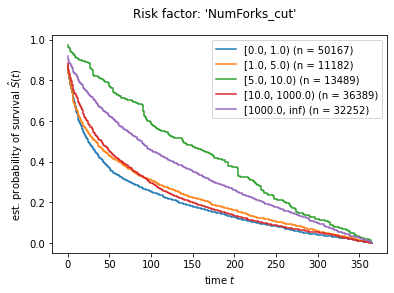

<Figure size 432x288 with 0 Axes>

In [255]:
print(values_names)
print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

<AxesSubplot: xlabel='NumForks', ylabel='Y'>

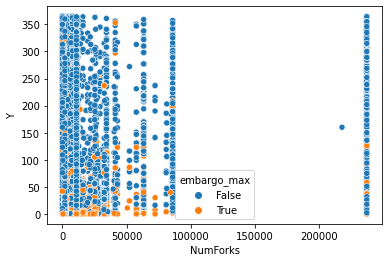

In [256]:
sns.scatterplot(data=df, x='NumForks', y='Y', hue='embargo_max')

----
**CommunitySize** (shared commits?)

In [257]:
df['CommunitySize'].describe()

count    143479.000000
mean       6068.361732
std       22037.718530
min           1.000000
25%           1.000000
50%           9.000000
75%         643.000000
max      154323.000000
Name: CommunitySize, dtype: float64

<AxesSubplot: ylabel='Count'>

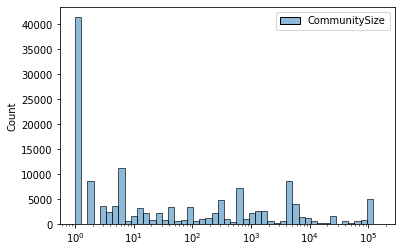

In [258]:
#sns.histplot(data=df[['CommunitySize']].dropna())
#plt.show()
sns.histplot(data=df[['CommunitySize']].dropna(), log_scale=True)
plt.show()

/tmp/ipykernel_3832658/1103352539.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


CommunitySize_cut
[1.0, 2.0)        41395
[2.0, 6.0)        18264
[6.0, 10.0)       12359
[10.0, 1000.0)    37714
[1000.0, inf)     33747
dtype: int64

CategoricalDtype(categories=[[1.0, 2.0), [2.0, 6.0), [6.0, 10.0), [10.0, 1000.0), [1000.0, inf)], ordered=True)

<AxesSubplot: xlabel='CommunitySize_cut', ylabel='CVE+project'>

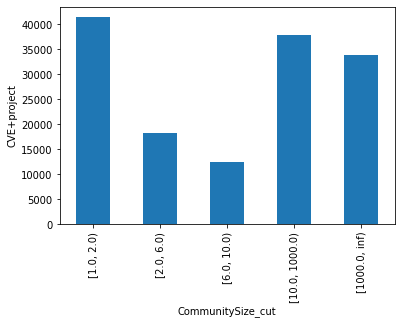

In [259]:
column_name = 'CommunitySize'
column_cut = column_name + '_cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,2,6,10,1e3,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [260]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

{0: Interval(1.0, 2.0, closed='left'),
 1: Interval(2.0, 6.0, closed='left'),
 2: Interval(6.0, 10.0, closed='left'),
 3: Interval(10.0, 1000.0, closed='left'),
 4: Interval(1000.0, inf, closed='left')}

In [261]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 143486, selected = 143479, uncensored = 143479
Computing 50 × bootstrap Dxy for 143479 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 143486,
    "Number of patients": 143479.0,
    "% of cohort": 99.99512147526588,
    "Survival days, median": 49.0,
    "Survival years, median": 0.13424657534246576,
    "Dxy (full)": 0.10171915561396139,
    "bootstrap": {
        "Dxy": 0.10196488910656981,
        "Confidence interval low": 0.10146499464052708,
        "Confidence interval high": 0.10246478357261254,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew
CommunitySize_cut,,,,,,,,,
"[1.0, 2.0)",41395,24.0,0,6.0,96.0,365,67.123372,89.805356,1.603402
"[2.0, 6.0)",18264,32.0,0,5.0,140.0,365,84.653581,104.250864,1.196237
"[6.0, 10.0)",12359,151.0,0,62.0,240.0,365,158.680557,106.970012,0.193696
"[10.0, 1000.0)",37714,43.0,0,10.0,122.0,365,82.390969,94.460717,1.329528
"[1000.0, inf)",33747,82.0,0,17.0,201.0,365,115.639968,110.244545,0.720067


In [262]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

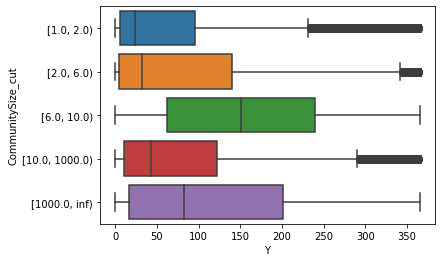

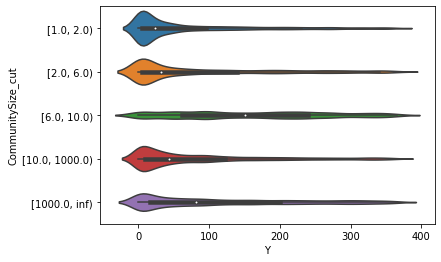

In [263]:
sns.boxplot(data=df, x="Y", y=column_cut)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

{0: Interval(1.0, 2.0, closed='left'), 1: Interval(2.0, 6.0, closed='left'), 2: Interval(6.0, 10.0, closed='left'), 3: Interval(10.0, 1000.0, closed='left'), 4: Interval(1000.0, inf, closed='left')}
dict_keys([0, 1, 2, 3, 4])
values_list = dict_keys([0, 1, 2, 3, 4])


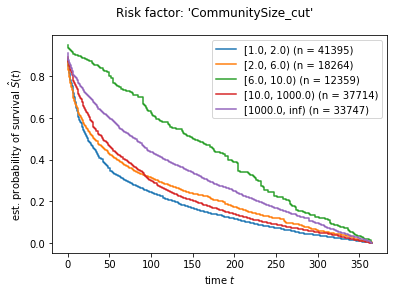

<Figure size 432x288 with 0 Axes>

In [264]:
print(values_names)
print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

<AxesSubplot: xlabel='CommunitySize', ylabel='Y'>

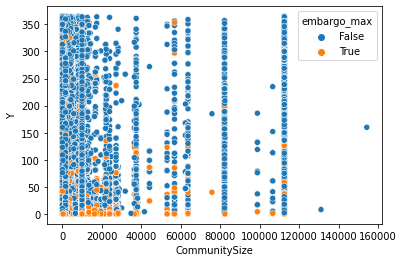

In [265]:
sns.scatterplot(data=df, x='CommunitySize', y='Y', hue='embargo_max')

### NumFiles and NumBlobs

In [266]:
column_name='NumFiles'

In [267]:
df['NumFiles'].describe()

count    1.434860e+05
mean     5.564255e+05
std      1.713812e+06
min      1.000000e+00
25%      1.196300e+04
50%      7.294300e+04
75%      2.240040e+05
max      4.307279e+07
Name: NumFiles, dtype: float64

<AxesSubplot: xlabel='Y'>

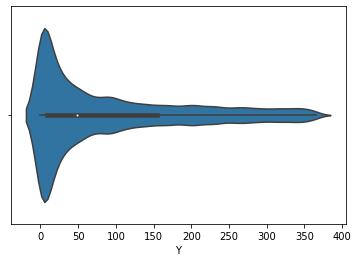

In [268]:
sns.violinplot(data=df[['Y','NumFiles']], x="Y")

<AxesSubplot: ylabel='Count'>

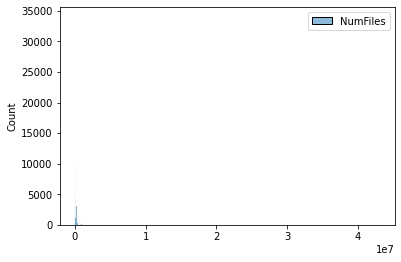

<AxesSubplot: ylabel='Count'>

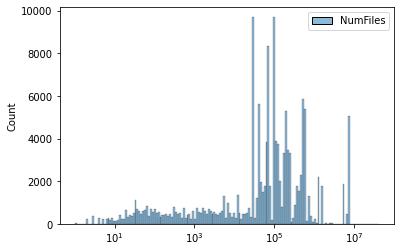

In [269]:
sns.histplot(data=df[[column_name]].dropna())
plt.show()
sns.histplot(data=df[[column_name]].dropna(), log_scale=True)
plt.show()

/tmp/ipykernel_3832658/3357549802.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumFiles_cut
[1.0, 50.0)              8793
[50.0, 1000.0)          13783
[1000.0, 100000.0)      53588
[100000.0, 500000.0)    42197
[500000.0, inf)         25125
dtype: int64

CategoricalDtype(categories=[[1.0, 50.0), [50.0, 1000.0), [1000.0, 100000.0), [100000.0, 500000.0), [500000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumFiles_cut', ylabel='CVE+project'>

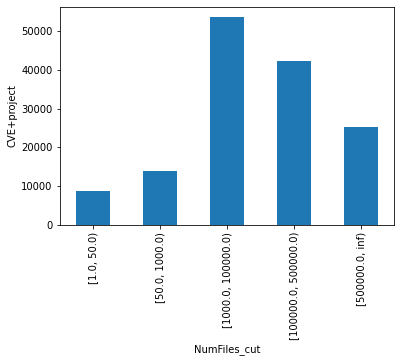

In [270]:
column_cut = column_name + '_cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,50,1e3,1e5,5e5,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [271]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

{0: Interval(1.0, 50.0, closed='left'),
 1: Interval(50.0, 1000.0, closed='left'),
 2: Interval(1000.0, 100000.0, closed='left'),
 3: Interval(100000.0, 500000.0, closed='left'),
 4: Interval(500000.0, inf, closed='left')}

In [272]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 143486, selected = 143486, uncensored = 143486
Computing 50 × bootstrap Dxy for 143486 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 143486,
    "Number of patients": 143486.0,
    "% of cohort": 100.0,
    "Survival days, median": 49.0,
    "Survival years, median": 0.13424657534246576,
    "Dxy (full)": 0.1225079538057483,
    "bootstrap": {
        "Dxy": 0.12265358426890566,
        "Confidence interval low": 0.12216417822147314,
        "Confidence interval high": 0.12314299031633817,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew
NumFiles_cut,,,,,,,,,
"[1.0, 50.0)",8793,22.0,0,4.0,97.0,365,67.859434,93.498027,1.583141
"[50.0, 1000.0)",13783,19.0,0,2.0,80.0,365,60.019372,86.937445,1.789761
"[1000.0, 100000.0)",53588,39.0,0,8.0,138.0,365,85.205400,99.342395,1.192130
"[100000.0, 500000.0)",42197,59.0,0,16.0,173.0,365,101.600991,102.954723,0.954754
"[500000.0, inf)",25125,83.0,0,19.0,209.0,365,120.168478,113.148999,0.672712


In [273]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

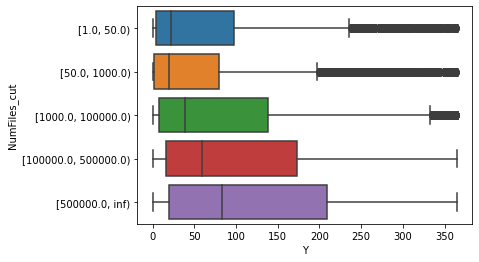

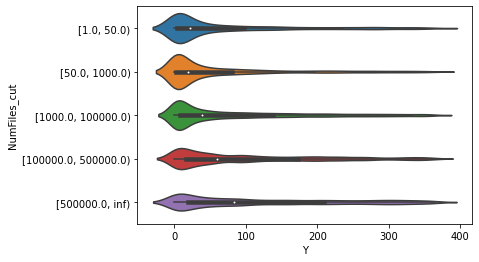

In [274]:
sns.boxplot(data=df, x="Y", y=column_cut)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

values_list = dict_keys([0, 1, 2, 3, 4])


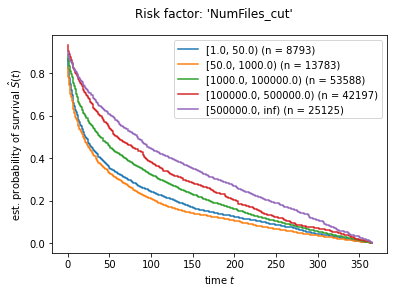

<Figure size 432x288 with 0 Axes>

In [275]:
#print(values_names)
#print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

<AxesSubplot: xlabel='NumFiles', ylabel='Y'>

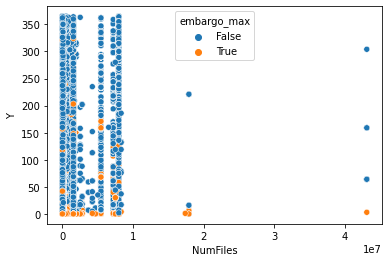

In [276]:
sns.scatterplot(data=df, x=column_name, y='Y', hue='embargo_max')

<AxesSubplot: xlabel='NumFiles', ylabel='Y'>

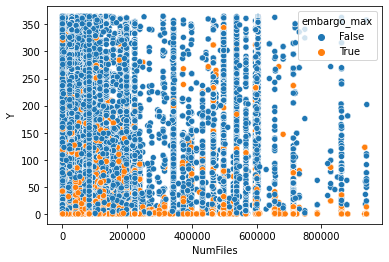

In [277]:
sns.scatterplot(data=df[df['NumFiles']<1e6], x=column_name, y='Y', hue='embargo_max')

----
**NumBlobs**

In [305]:
column_name='NumBlobs'

<AxesSubplot: xlabel='NumFiles', ylabel='NumBlobs'>

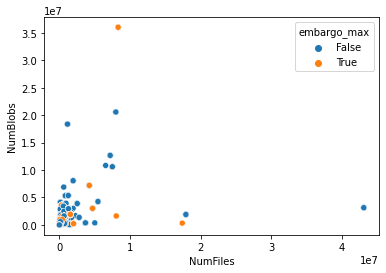

<AxesSubplot: xlabel='NumFiles', ylabel='NumBlobs'>

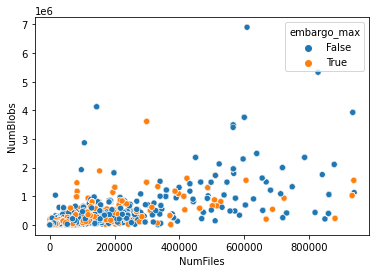

In [278]:
sns.scatterplot(data=df, x='NumFiles', y='NumBlobs', hue='embargo_max')
plt.show()
sns.scatterplot(data=df[df['NumFiles']<1e6], x='NumFiles', y='NumBlobs', hue='embargo_max')
plt.show()

In [301]:
df[['Y','NumFiles','NumBlobs']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143486 entries, 36 to 287883
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   Y         143486 non-null  int64
 1   NumFiles  143486 non-null  Int64
 2   NumBlobs  143486 non-null  Int64
dtypes: Int64(2), int64(1)
memory usage: 4.7 MB


<AxesSubplot: ylabel='Count'>

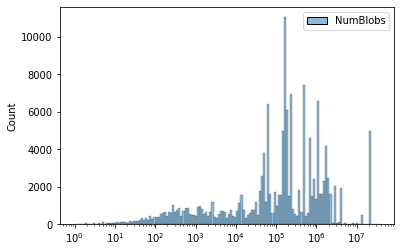

In [307]:
#sns.histplot(data=df[[column_name]].dropna())
#plt.show()
sns.histplot(data=df[[column_name]].dropna(), log_scale=True)
plt.show()

/tmp/ipykernel_3832658/2070229058.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumBlobs_cut
[1.0, 500.0)             12521
[500.0, 10000.0)         15532
[10000.0, 100000.0)      28410
[100000.0, 1000000.0)    56773
[1000000.0, inf)         30250
dtype: int64

CategoricalDtype(categories=[[1.0, 500.0), [500.0, 10000.0), [10000.0, 100000.0), [100000.0, 1000000.0), [1000000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumBlobs_cut', ylabel='CVE+project'>

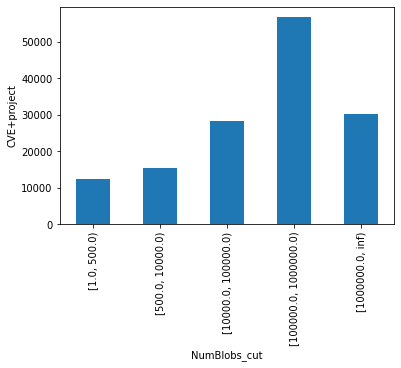

In [308]:
column_cut = column_name + '_cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,5e2,1e4,1e5,1e6,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [309]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

{0: Interval(1.0, 500.0, closed='left'),
 1: Interval(500.0, 10000.0, closed='left'),
 2: Interval(10000.0, 100000.0, closed='left'),
 3: Interval(100000.0, 1000000.0, closed='left'),
 4: Interval(1000000.0, inf, closed='left')}

In [310]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 143486, selected = 143486, uncensored = 143486
Computing 50 × bootstrap Dxy for 143486 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 143486,
    "Number of patients": 143486.0,
    "% of cohort": 100.0,
    "Survival days, median": 49.0,
    "Survival years, median": 0.13424657534246576,
    "Dxy (full)": 0.05231870437671371,
    "bootstrap": {
        "Dxy": 0.052380104538988996,
        "Confidence interval low": 0.051871059447904724,
        "Confidence interval high": 0.05288914963007327,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew
NumBlobs_cut,,,,,,,,,
"[1.0, 500.0)",12521,22.0,0,4.0,92.0,365,66.293507,91.190508,1.642658
"[500.0, 10000.0)",15532,29.0,0,3.0,117.0,365,74.241630,95.702993,1.377176
"[10000.0, 100000.0)",28410,54.0,0,12.0,153.0,365,94.839740,100.149666,1.042819
"[100000.0, 1000000.0)",56773,56.0,0,10.0,184.0,365,103.309390,109.132814,0.906830
"[1000000.0, inf)",30250,51.0,0,12.0,146.0,365,91.029719,98.948471,1.115699


In [311]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

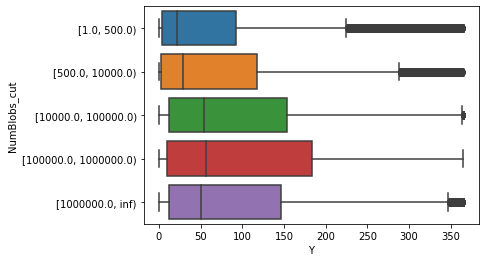

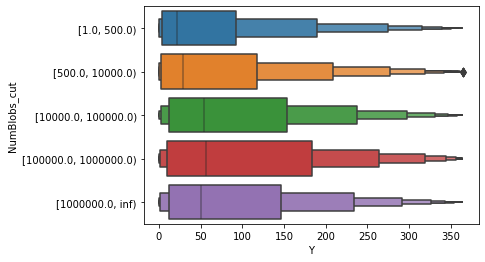

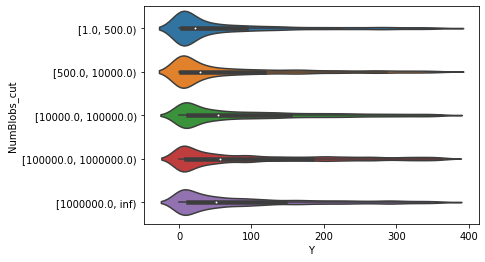

In [312]:
sns.boxplot(data=df, x="Y", y=column_cut)
plt.show();
sns.boxenplot(data=df, x="Y", y=column_cut)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

values_list = dict_keys([0, 1, 2, 3, 4])


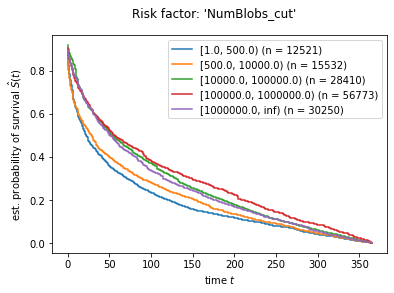

<Figure size 432x288 with 0 Axes>

In [313]:
#print(values_names)
#print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

<AxesSubplot: xlabel='NumBlobs', ylabel='Y'>

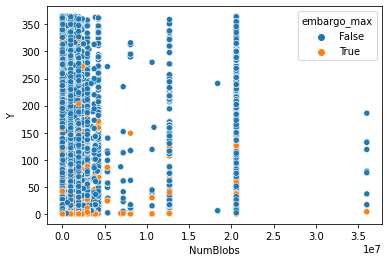

In [314]:
sns.scatterplot(data=df, x=column_name, y='Y', hue='embargo_max')

## Summary

In [315]:
summary_df=pd.DataFrame.from_dict(results_summary, orient='index')
summary_df

,% of cohort,Dxy,Dxy_low,Dxy_high,cohort
NumCore_cut,99.960972,0.057984,0.057659,0.057659,NaN
NumAuthors_cut,99.960972,0.046375,0.045882,0.045882,NaN
NumCore/NumAuthors cut,99.960972,0.081352,0.080966,0.080966,NaN
NumCommits_cut,99.889885,-0.033881,-0.034343,-0.034343,NaN
NumCommits_cut2,99.889885,-0.020236,-0.020664,-0.020664,NaN
NumActiveMon [%] cut,99.999303,-0.111680,-0.112069,-0.112069,NaN
NumActiveMon_cut,100.000000,-0.079877,-0.080328,-0.080328,NaN
CommitDateRange [days] cut,100.000000,0.002866,0.002466,0.002466,NaN
NumStars_cut,74.259510,0.016434,0.015893,0.015893,NaN
NumStars_cut+NumStars<10000,61.874329,-0.045278,-0.045943,-0.045943,NaN


<AxesSubplot: title={'center': 'Dxy'}>

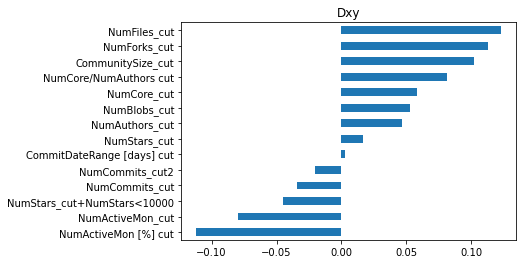

In [326]:
summary_df['Dxy'].sort_values().plot(kind='barh',title='Dxy')

In [280]:
ver='1'
summary_df.to_csv(f"survey_analysis_project_metadata-{ver}.csv")